# 0.make folders and data downloads

In [1]:
import os
import urllib.request
import zipfile
import tarfile

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive/[TNT] 21-winter Pytorch/pytorch_advanced-kr/4_pose_estimation')

In [4]:
data_dir = './data/'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)

In [5]:
weights_dir = './weights/'
if not os.path.exists(weights_dir):
  os.mkdir(weights_dir)

In [6]:
# MSCOCO  2014 val images download
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
  urllib.request.urlretrieve(url, target_path)

  zip = zipfile.ZipFile(target_path)
  zip.extractall(data_dir)
  zip.close()

In [7]:
# 이미지  데이터의 어노테이션 데이터를 정리한 파일
# COCO.json file  download
url = "https://www.dropbox.com/s/0sj2q24hipiiq5t/COCO.json?dl=1"  # dl=1로 변경해야 강제 다운로드 가능
target_path = os.path.join(data_dir, "COCO.json") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [8]:
# 이미지 중에서 어노테이션 데이터(사람의 관절 위치 정보)가 없는 사람 부분을 마스크하는 데이터 준비
url = "https://www.dropbox.com/s/bd9ty7b4fqd5ebf/mask.tar.gz?dl=0"
target_path = os.path.join(data_dir, "mask.tar.gz") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [ ]:
# mask.tar.gz 압축 해제
save_path = os.path.join(data_dir, 'mask.tar.gz')
with tarfile.open(save_path, 'r:*') as tar:
  tar.extractall(data_dir)

In [9]:
# tensorboy의 학습된 OpenPose 모델 "pspnet50_30.pth"를 준비

# "weights" 폴더에 이하 데이터를 배치
# 학습된 모델 "pose_model_scratch.pth"

url = "https://www.dropbox.com/s/5v654d2u65fuvyr/pose_model_scratch.pth?dl=0"
target_path = os.path.join(weights_dir, "pose_model_scratch.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

# 1.DataLoader

In [10]:
# 필요한 패키지 import
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

## 1-1. 이미지, 마스크이미지, 어노테이션 데이터의 파일 경로 리스트 작성

In [11]:
def make_datapath_list(rootpath):
    """
    학습 및 검증의 화상 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트를 작성한다.
    """

    # 어노테이션의 JSON 파일을 읽기
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # index를 저장
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 화상 파일 경로를 저장
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # 마스크 데이터의 경로를 저장
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # 어노테이션 데이터를 저장
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [18]:
# 동작 확인
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath='./data/')

val_meta_list[24]


{'annolist_index': 18.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'bbox_other': [[112.24, 245.32, 127.0, 110.76],
  [34.67, 208.02, 91.24, 152.36]],
 'dataset': 'COCO_val',
 'image_id': 488.0,
 'img_height': 406.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'isValidation': 1.0,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [127.0, 311.0, 1.0],
   [170.0, 307.0, 1.0],
   [180.0, 310.0, 1.0],
   [140.0, 341.0, 1.0],
   [148.0, 346.0, 1.0]],
  [[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [106.0, 227.0, 1.0],
   [92.0, 232.0, 1.0],
   [101.0, 232.0, 1.0],
   [0.0, 0.0, 2.0],
   [97.0, 257.0, 1.0],
   [0.0, 0.0, 2.0],
   [94.0, 282.0, 1.0],
   [55.0, 270.0, 1.0],
   [65.0, 271.0, 1.0

In [20]:
val_mask_list[24]

'./data/mask/val2014/mask_COCO_val2014_000000000488.jpg'

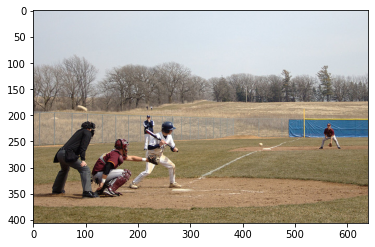

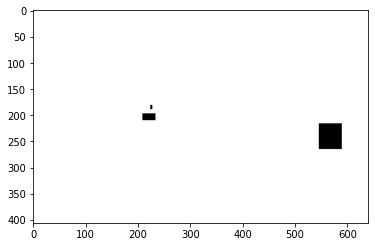

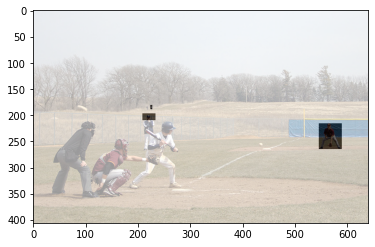

In [21]:
# 마스크 데이터 동작 확인
index = 24

# image
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# mask
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 합성
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

## 1-2. 이미지 전처리

In [22]:
# 데이터 처리 클래스와 데이터 확장 클래스를 import
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
  '''
  이미지, 마스크, 어노테이션의 전처리 클래스.
  학습시와 추론시 다르게  동작
  학습시에는 데이터 확장 수행
  '''

  def __init__(self):
    self.data_transform = {'train': Compose([get_anno(),
                                             add_neck(),
                                             aug_scale(),
                                             aug_rotate(),
                                             aug_croppad(),
                                             aug_flip(),
                                             remove_illegal_joint(),
                                             # Normalize_Tensor(),
                                             no_Normalize_Tensor()]),
                           'val': Compose([
                                           # 검증 생략
                           ])
                           }
                      
  def __call__(self, phase, meta_data, img, mask_miss):
    '''
    Parameters
    ----------
    phase: 'train' or 'val'
      전처리 모드 지정
    '''
    meta_data, img, mask_miss = self.data_transform[phase](
        meta_data, img, mask_miss
    )
    return meta_data, img, mask_miss




In [ ]:
# 동작 확인
# read image
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 이미지 전처리
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

# 이미지 표시
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# 마스크 표시
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 합성 RGB 정보 갖추기
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

## 1-3. 훈련 데이터의 정답 정보로 사용하는 어노테이션 데이터 작성

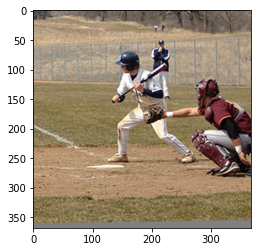

In [36]:
from utils.dataloader import get_ground_truth

# 화상 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 화상 전처리
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPose의 어노테이션 데이터 생성
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 화상 표시
plt.imshow(img)
plt.show()

In [ ]:
# 왼쪽 팔꿈치의 heatmap 확인

# 원래 이미지
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), 
                      interpolation=cv2.INTER_CUBIC)
# 주의: heatmap은 이미지 크기가 1/8로 되어 있으므로 확대한다

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [38]:
# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

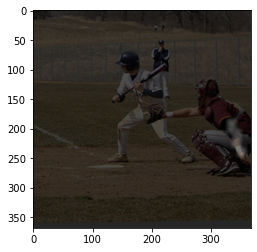

In [39]:
# 왼쪽 팔꿈치와 왼쪽 손목에 PAF를 확인
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()


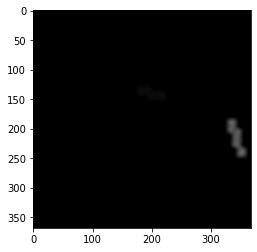

In [40]:
# PAF만 표시
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)


## 1-4. Dataset 

In [43]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCO Cocokeypoints의 Dataset를 작성하는 클래스. PyTorch Dataset 클래스를 상속.

    Attributes
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정.
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''화상의 Tensor 형식 데이터, 어노테이션, 마스크를 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]

        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 화상 전처리
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 정답 어노테이션 데이터 취득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. 마스크 데이터는 RGB가 (1,1,1) 또는 (0,0,0)이므로, 차원을 낮춘다
        # 마스크된 위치는 값이 0, 그렇지 않으면 1입니다
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. 채널이 맨 끝에 있으므로, 순서를 변경
        # 예: paf_mask: torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask


In [44]:
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# 데이터 꺼내기 예
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


## 1-5. DataLoader

In [45]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복으로 변환
item = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


# 2.Network Model (OpenPose)

In [46]:
# 필요한 패키지 import
import torch
import torch.nn as nn
from torch.nn import init
import torchvision

## 2-1. Network

In [48]:
class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()

        # Feature 모듈
        self.model0 = OpenPose_Feature()

        # Stage 모듈
        # PAFs(Part Affinity Fields)
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')

        # confidence heatmap
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')

    def forward(self, x):
        # Feature 모듈
        out1 = self.model0(x)

        # Stage1
        out1_1 = self.model1_1(out1)    # PAFs
        out1_2 = self.model1_2(out1)    # confidence heatmap

        # Stage2
        out2 = torch.cat([out1_1, out1_2, out1], 1)   # 1차원의 채널 결합
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)

        # Stage3
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)

        # Stage4
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)

        # Stage5
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)

        # Stage6
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        # 손실 계산을 위해 각 Stage 결과를 저장
        saved_for_loss = []
        saved_for_loss.append(out1_1)   # PAFs
        saved_for_loss.append(out1_2)   # confidence heatmap
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        # 최종적인 PAFs의 out6_1과 confidence heatmap의 out6_2, 그리고
        # 손실 계산용으로 각 단계에서 PAFs와 heatmap을 저장한 saved_for_loss를 출력
        # out6_1: torch.Size([minibatch, 38, 46, 46])
        # out6_2: torch.Size([minibatch, 19, 46, 46])
        # saved_for_loss:[out1_1, out_1_2, ・・・, out6_2]

        return (out6_1, out6_2), saved_for_loss

# 2-2. Feature 모듈

In [49]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()

        # VGG-19의 최초 10개의 합성곱 사용
        vgg19 =  torchvision.models.vgg19(pretrained=True)
        model = {}
        model['block0'] = vgg19.features[0:23] #  VGG-19의 최초 10개 (0~22) 사용

        # 나머지는 새로운 합성곱 층 2개 준비
        model['block0'].add_module('23', torch.nn.Conv2d(
            512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("24", torch.nn.ReLU(inplace=True))
        model['block0'].add_module("25", torch.nn.Conv2d(
            256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("26", torch.nn.ReLU(inplace=True))

        self.model = model['block0']

    def forward(self, x):
        outputs = self.model(x)
        return  outputs



## 2-3. Stage 모듈

In [54]:
def make_OpenPose_block(block_name):
    '''
    OpenPose의 Stage모듈의 block을 작성
    nn.Module이 아니라 nn.Sequential로 작성
    '''
    
    # 1. 사전형 변수 blocks를 작성하여 네트워크를 생성
    # 사전을 준비하고 block_name 인수만을 생성
    blocks = {}
    # Stage 1
    blocks['block1_1'] = [
                          {'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}
                          ]

    blocks['block1_2'] = [
                          {'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}
                          ]

    # Stage 2-6
    for i in range(2, 7):
        blocks['block%d_1' %i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # block_name 인수의 구성 사전을 꺼냄
    cfg_dict = blocks[block_name]

    # 구성 내용을 리스트 변수 layers에 저장
    layers = []

    # 0번째부터 마지막 층까지 잓성
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    # 3. layers를 Sequential로
    # 단 마지막에 ReLU 필요 없으므로 직전까지만 사용
    net = nn.Sequential(*layers[:-1])

    # 4. 초기화함수  설정, 합성곱 층 초기화
    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    net.apply(_initialize_weights_norm)

    return net


In [55]:
# 동작 확인
# 모델 정의
net = OpenPoseNet()
net.train()

# 더미 데이터 작성
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 계산
outputs = net(dummy_img)
print(outputs)

((tensor([[[[ 7.0396e-06,  3.3628e-05,  4.3208e-05,  ...,  5.0540e-06,
           -2.5404e-06,  9.1405e-06],
          [ 2.9025e-05,  6.4349e-05,  5.5344e-05,  ...,  1.4241e-07,
           -3.2599e-06,  2.0806e-07],
          [ 1.4152e-05,  5.7443e-05,  5.1578e-05,  ...,  2.6662e-05,
           -2.0920e-05,  2.2890e-06],
          ...,
          [-1.0638e-06, -1.1684e-05, -6.0669e-06,  ..., -6.7278e-05,
           -7.5098e-05, -4.7268e-05],
          [ 2.3275e-05,  8.7200e-06,  7.1009e-06,  ..., -2.8950e-05,
           -2.1674e-05, -2.1010e-05],
          [ 6.4497e-06,  2.3084e-06, -6.5771e-06,  ..., -1.3351e-05,
           -3.0039e-05, -2.6824e-05]],

         [[-3.0074e-06, -1.1749e-05, -5.9522e-06,  ...,  3.1722e-06,
           -2.3991e-05,  1.1142e-05],
          [-1.3738e-05, -1.9233e-05, -1.8236e-05,  ..., -1.2264e-06,
            5.4099e-06,  9.5048e-06],
          [-1.1018e-05, -8.8490e-06,  4.8147e-06,  ..., -1.6548e-05,
            4.7003e-06,  1.0292e-06],
          ...,
   

# *TensorBoardX

In [56]:
import torch

In [57]:
from utils.openpose_net import OpenPoseNet

net = OpenPoseNet()
net.train()

OpenPoseNet(
  (model0): OpenPose_Feature(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

In [59]:
# !pip install tensorboardX

     |████████████████████████████████| 124 kB 6.8 MB/s 


In [61]:
%load_ext tensorboard
%tensorboard —logdir {"./tbx/"}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: invalid choice: '—logdir' (choose from 'serve', 'dev')

In [60]:
# 1. tensorboardx의 저장 클래스 호출
from tensorboardX import SummaryWriter

# 2. 'tbX' 폴더에 저장할 writer 준비
# 'tbX' 폴더가 없으면 자동으로 작성됨
writer = SummaryWriter('./tbX')

# 3. 네트워크에 넣을 더미데이터 작성
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 4. OpenPose의 인스턴스 net에 대해, 더미데이터인
# dummy_img를 전달할 때, graph를 writer에 저장
writer.add_graph(net, (dummy_img, ))
writer.close()


# 5. 명령 프롬프트를 열고, "tbX"가 있는
# "4_pose_estimation" 폴더까지 이동하여,
# 다음 명령을 실행합니다

# tensorboard --logdir="./tbX/"

# 그 후, http://localhost:6006
# 에 접근합니다

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:965: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  argument_names,


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:965: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  argument_names,


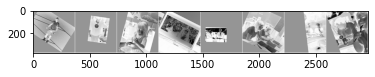

In [63]:
from utils.openpose_net import OpenPoseNet

net = OpenPoseNet()
net.train()

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/OpenPose')

dataiter = iter(train_dataloader)
images = dataiter.next()[0]

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다
writer.add_image('batched images', img_grid)
writer.add_graph(net, images)
writer.close()

# 3.Training OpenPose

In [64]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [65]:
# 초기 설정
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 3-1. DataLoader

In [66]:
from utils.dataloader import make_datapath_list, DataTransform, COCOkeypointsDataset

# MS COCO 파일 경로 리스트 작성
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

# Dataset 작성
# 이 책에서는 데이터 양의 관계로 train을 val_list에서 작성하는 점에 주의
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())

# 이번에는 간이 학습으로써, 검증 데이터를 작성하지 않음
# val_dataset = CocokeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# DataLoader 작성
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader = data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수로 정리
# dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict = {"train": train_dataloader, "val": None}

## 3-2. Network Model

In [67]:
from utils.openpose_net import OpenPoseNet
net = OpenPoseNet()

## 3-3. Loss Function

In [68]:
# 손실함수 설정
class OpenPoseLoss(nn.Module):
    """OpenPose의 손실함수 클래스"""

    def __init__(self):
        super(OpenPoseLoss, self).__init__()

    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        """
        손실함수 계산.

        Parameters
        ----------
        saved_for_loss : OpenPoseNet의 출력(리스트)

        heatmap_target : [num_batch, 19, 46, 46]
            정답 부위의 어노테이션 정보

        heatmap_mask : [num_batch, 19, 46, 46]
            heatmap 화상의 mask

        paf_target : [num_batch, 38, 46, 46]
            정답 PAF의 어노테이션 정보

        paf_mask : [num_batch, 38, 46, 46]
            PAF 화상의 mask

        Returns
        -------
        loss : 텐서
            손실값
        """
        total_loss = 0
        # 스테이지마다 계산
        for j in range(6):

            # PAFs 및 heatmaps에서 마스크된 부분(paf_mask=0 등)은 무시
            # PAFs
            pred1 = saved_for_loss[2*j] * paf_mask
            gt1 = paf_target.float() * paf_mask

            # heatmaps
            pred2 = saved_for_loss[2*j+1] * heat_mask
            gt2 = heatmap_target.float() * heat_mask

            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')

        return total_loss

criterion = OpenPoseLoss()

## 3-4. Optimization

In [69]:
optimizer = optim.SGD(net.parameters(), lr=1e-2,
                      momentum=0.9,
                      weight_decay=0.0001)

## 3-5. Training

In [70]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 네트워크를 GPU로
    net.to(device)

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # 반복 카운터 설정
    iteration = 1

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epoch의 손실합
        epoch_val_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 훈련 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
                optimizer.zero_grad()
                print('(train)')

            # 이번에는 검증을 생략
            else:
                continue
                # net.eval()   # 모델을 검증 모드로
                # print('-------------')
                # print('(val)')

            # 데이터 로더에서 minibatch씩 꺼내는 루프
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
                if imges.size()[0] == 1:
                    continue

                # GPU가 사용 가능하면 GPU로 데이터를 보낸다
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # optimizer 초기화
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    # (out6_1, out6_2)는 사용하지 않으므로 _ 로 대체
                    _, saved_for_loss = net(imges)

                    loss = criterion(saved_for_loss, heatmap_target,
                                     heat_mask, paf_target, paf_mask)
                    del saved_for_loss
                    # 훈련시에는 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iter에 1번, loss를 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 검증시
                    # else:
                        #epoch_val_loss += loss.item()

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, 0))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 마지막 네트워크를 저장한다
    torch.save(net.state_dict(), 'weights/openpose_net_' +
               str(epoch+1) + '.pth')


In [71]:
# 학습 및 검증을 실행한다
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용 장치:  cuda:0
-------------
Epoch 1/2
-------------
(train)
반복 10 || Loss: 0.0093 || 10iter: 235.4190 sec.
반복 20 || Loss: 0.0082 || 10iter: 188.2004 sec.
반복 30 || Loss: 0.0068 || 10iter: 164.7308 sec.
반복 40 || Loss: 0.0057 || 10iter: 150.4445 sec.
반복 50 || Loss: 0.0048 || 10iter: 125.6711 sec.
반복 60 || Loss: 0.0044 || 10iter: 123.5903 sec.
반복 70 || Loss: 0.0037 || 10iter: 117.3864 sec.
반복 80 || Loss: 0.0030 || 10iter: 114.2435 sec.
반복 90 || Loss: 0.0027 || 10iter: 113.7789 sec.
반복 100 || Loss: 0.0026 || 10iter: 102.2007 sec.
반복 110 || Loss: 0.0021 || 10iter: 104.0508 sec.
반복 120 || Loss: 0.0022 || 10iter: 84.0128 sec.
반복 130 || Loss: 0.0020 || 10iter: 84.8995 sec.
반복 140 || Loss: 0.0018 || 10iter: 94.2982 sec.
반복 150 || Loss: 0.0019 || 10iter: 79.3354 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.0043 ||Epoch_VAL_Loss:0.0000
timer:  1910.7744 sec.
-------------
Epoch 2/2
-------------
(train)
반복 160 || Loss: 0.0017 || 10iter: 27.9481 sec.
반복 170 || Loss: 0.0016 || 10iter: 41.3655 s

# 4.Inference

In [72]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [73]:
from utils.openpose_net import OpenPoseNet

# 학습된 모델과 이 장의 모델은 네트워크 계층의 이름이 다르므로 대응시켜 로드
# 모델 정의
net = OpenPoseNet()

# 학습된 파라미터 읽기
net_weights = torch.load(
    './weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# 로드한 내용을 이 책에서 구축한 모델의
# 파라미터명 net.state_dict().keys()로 복사
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# 복사한 내용을 모델에 할당
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')


네트워크 설정 완료: 학습된 가중치를 로드했습니다


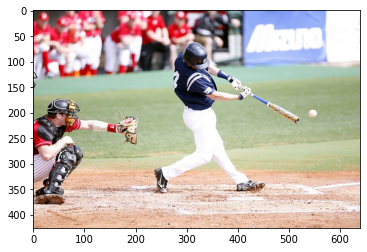

In [74]:
# 야구 이미지 읽고, 전처리
test_image = './data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,R의 순서

# BGR을 RGB로 하여 표시
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 이미지 리사이즈
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 이미지 전처리
img = img.astype(np.float32) / 255.

# 색상 정보 표준화
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# (높이, 폭, 색) → (색, 높이, 폭)
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 이미지를  Tensor로
img = torch.from_numpy(img)

# 미니 배치화: torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [75]:
# OpenPose로 heatmaps과 PAFs를 구합니다
net.eval()
predicted_outputs, _ = net(x)

# 이미지를 텐서에서 NumPy로 변환해, 크기를 반환합니다
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

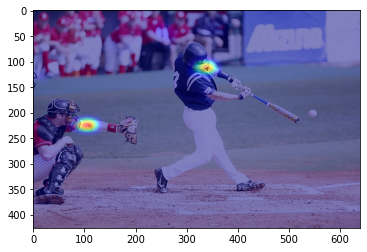

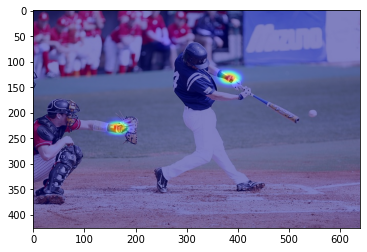

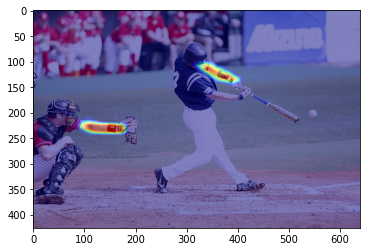

In [76]:
# 왼쪽 팔꿈치와 왼쪽 손목의 heatmap, 그리고 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터를 시각화
# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [77]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

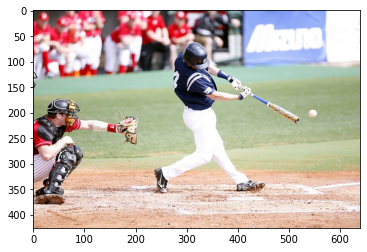

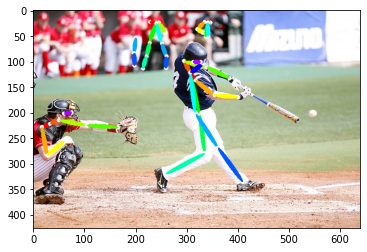

In [78]:
# 결과 그리기
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()